In [1]:
#@title
# !git clone https://github.com/thsant/wgisd.git
HEIGHT, WIDTH = 1365, 2048
MASKTHRESH = 0.5
# from google.colab import drive
# drive.mount('/googledrive')
# MODELPATH = '/googledrive/MyDrive/uczelnia/computer_vision/instance_segmentation_grapes/models/'
MODELPATH = './'
from random import shuffle
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.ssd import det_utils
from torchvision.ops import nms
import torchvision
import logging
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import warnings
import random
import colorsys
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Polygon
from skimage.color import label2rgb
import torch.nn.functional as F
from torchvision.ops import roi_align
from torchvision.models.detection.roi_heads import project_masks_on_boxes
from time import time
from pathlib import Path
import json
import cv2
import pandas as pd


class WGISDMaskedDataset(Dataset):
    def __init__(self, root, transforms=None, source='train'):
        self.root = root
        self.transforms = transforms
        
        if source not in ('train', 'test', 'valid'):
            print('source should be by "train" or "test"')
            return None

        srcpref = source
        if source == 'valid':
            srcpref = 'test'
        source_path = os.path.join(root, f'{srcpref}_masked.txt')
        with open(source_path, 'r') as fp:
          lines = fp.readlines()
          ids = [l.rstrip() for l in lines if len(l)>=3]# removes /n at the end of each line

        self.imgs = [os.path.join(root, 'data', f'{id}.jpg') for id in ids]
        self.masks = [os.path.join(root, 'data', f'{id}.npz') for id in ids]
        self.boxes = [os.path.join(root, 'data', f'{id}.txt') for id in ids]

        #performing additional dataset split test -> test, valid
        if source == 'test':
            self.imgs = self.imgs[(len(self.imgs)+1) // 2 : ]
            self.masks = self.masks[(len(self.masks)+1) // 2 : ]
            self.boxes = self.boxes[(len(self.boxes)+1) // 2 : ]
        elif source == 'valid':
            self.imgs = self.imgs[ : (len(self.imgs)+1) // 2 ]
            self.masks = self.masks[ : (len(self.masks)+1) // 2 ]
            self.boxes = self.boxes[ : (len(self.boxes)+1) // 2 ]

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        box_path = self.boxes[idx]

        img = cv2.imread(img_path)
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, _ = img.shape
        wgisd_masks = np.load(mask_path)['arr_0'].astype(np.uint8)
        num_objs = wgisd_masks.shape[-1]
        all_text = np.loadtxt(box_path, delimiter = " ", dtype = np.float32)
        wgisd_boxes = all_text[:,1:]
        assert(wgisd_boxes.shape[0] == num_objs)
        boxes = []
        for box in wgisd_boxes:
            x1 = box[0] - box[2]/2
            x2 = box[0] + box[2]/2
            y1 = box[1] - box[3]/2
            y2 = box[1] + box[3]/2
            boxes.append([x1 * width, y1 * height, x2 * width, y2 * height])
        masks = np.moveaxis(wgisd_masks, -1, 0)
        labels = np.ones(num_objs, dtype=np.int64)
        if self.transforms is None:
            pass
        else:
            masks = list(masks)
            augmented = self.transforms(image=img, masks = masks, bboxes = boxes, class_labels = labels) 
            img = augmented['image']
            boxes = augmented['bboxes']
            masks = augmented['masks']
            img = np.asarray(img)

        img = np.array(img)
        # Normalize
        img = (img - img.min()) / np.max([img.max() - img.min(), 1])
        # torch expects channels as first input:
        img = np.moveaxis(img, -1, 0)
        img = torch.as_tensor(img, dtype=torch.float32)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id
        }

        return img, target

    def __len__(self):
        return len(self.imgs)


def filter_results(results : dict, confidence_thresh = 0.8):
    res = results.copy()
    scores = results['scores']
    res['boxes'] = results['boxes'][scores > confidence_thresh]
    res['labels'] = results['labels'][scores >confidence_thresh]
    res['masks'] = results['masks'][scores>confidence_thresh]
    res['scores'] = results['scores'][scores > confidence_thresh]
    return res

def nmscombined(orig_predicted, iou_thresh = 0.3):
    '''
    performs non max suppression on the results
    '''
    keep = nms(orig_predicted['boxes'], orig_predicted['scores'], iou_thresh)
    final_pred = orig_predicted
    final_pred['boxes'] = final_pred['boxes'][keep]
    final_pred['masks'] = final_pred['masks'][keep]
    final_pred['scores'] = final_pred['scores'][keep]
    final_pred['labels'] = final_pred['labels'][keep]
    return final_pred

def calcTP(GTmasks, predmasks, predscores, IoU_thresh = 0.5, maskthresh = MASKTHRESH):
    """
    Parameters
    ----------
    GTmasks : Ground Truth masks
    predmasks : Predicted Masks from the model
    
    Returns
    ------------
    TruePositives
    """
    predmasks = predmasks > maskthresh
    metric = 0
    GTmasksEvaluated = [False for i in range(GTmasks.shape[0])]
    TP = 0
    for predmask in predmasks[predscores.argsort(descending = True)]:
        andresult=torch.logical_and(GTmasks, predmask )
        imgid = torch.argmax(andresult.sum([-1, -2]))
        if GTmasksEvaluated[imgid]:
            continue
        gtmask = GTmasks[imgid]
        intersection = andresult[imgid]
        union = torch.logical_or(gtmask, predmask)
        iou = intersection.sum() / union.sum()
        if iou >= IoU_thresh:
            GTmasksEvaluated[imgid] = True
            TP += 1
    return TP

def precision_frompreds(GTmasks, predmasks, predscores, IoU_thresh = 0.5, maskthresh = MASKTHRESH):
    TP = calcTP(GTmasks, predmasks, predscores, IoU_thresh, maskthresh)
    return TP / predmasks.shape[0]

def recall_frompreds(GTmasks, predmasks, predscores, IoU_thresh = 0.5,maskthresh = MASKTHRESH):
    TP = calcTP(GTmasks, predmasks, predscores, IoU_thresh, maskthresh)
    return TP / GTmasks.shape[0]

def fscore(precision, recall):
    return 2 * precision * recall / (precision + recall)

def print_datsetslens():
    train=WGISDMaskedDataset('./wgisd/', source='train')
    test=WGISDMaskedDataset('./wgisd/', source='test')
    valid = WGISDMaskedDataset('./wgisd/', source='valid')
    print('trainlen:', len(train))
    print('testlen:', len(test))
    print('validlen:', len(valid))
    den = len(train) + len(valid) + len(test)
    print(f'split proportion: {len(train) / den} : {len(test) / den} : {len(valid) / den}')

class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class IoULoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU


class LossIntoMaskRCNN(object):
    def __init__(self, lossfunction = 'bincrossentr_wl'):
        if lossfunction == 'bincrossentr_wl':
            self.loss = F.binary_cross_entropy_with_logits
        elif lossfunction == 'mse':
            self.loss = F.mse_loss
        elif lossfunction =='dice':
            self.loss = DiceLoss()
        elif lossfunction == 'iou':
            self.loss = IoULoss()
    def lossintomaskrcnn(self, mask_logits, proposals, gt_masks, gt_labels, mask_matched_idxs, loss = 'bincrossentr_wl'): 
        # type: (Tensor, List[Tensor], List[Tensor], List[Tensor], List[Tensor]) 
        """ 
        Arguments: 
            proposals (list[BoxList]) 
            mask_logits (Tensor) 
            targets (list[BoxList]) 

        Return: 
            mask_loss (Tensor): scalar tensor containing the loss 
        """ 

        discretization_size = mask_logits.shape[-1] 
        labels = [l[idxs] for l, idxs in zip(gt_labels, mask_matched_idxs)] 
        mask_targets = [ 
            project_masks_on_boxes(m, p, i, discretization_size) 
            for m, p, i in zip(gt_masks, proposals, mask_matched_idxs) 
        ] 

        labels = torch.cat(labels, dim=0) 
        mask_targets = torch.cat(mask_targets, dim=0) 

        # torch.mean (in binary_cross_entropy_with_logits) doesn't 
        # accept empty tensors, so handle it separately 
        if mask_targets.numel() == 0: 
            return mask_logits.sum() * 0 

        mask_loss = self.loss( 
            mask_logits[torch.arange(labels.shape[0], device=labels.device), labels], mask_targets 
        ) 
        return mask_loss

def availablelosses():
    return ['bincrossentr_wl', 'dice', 'iou', 'mse']
def availablelosses_tofunctions():
    return {'bincrossentr_wl':F.binary_cross_entropy_with_logits, 'dice':DiceLoss(), 'iou':IoULoss(),'mse':F.mse_loss}

def setloss(loss = 'bincrossentr_wl'):
    lossIMRCNN = LossIntoMaskRCNN(loss)
    torchvision.models.detection.roi_heads.maskrcnn_loss = lossIMRCNN.lossintomaskrcnn 

def eager_outputs_foo(losses, detections):
    return losses, detections

def get_maskrcnn(pretrained = True):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #replace head predictor (boxes)
    NUM_CLASSES=2
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    #replace mask predictor
    fg_iou_thresh = 0.5 #min IoU to be considered as positive
    bg_iou_thresh = 0.5 #max IoU to be considered as negative
    model.roi_heads.proposal_matcher.low_threshold = bg_iou_thresh
    model.roi_heads.proposal_matcher.high_threshold = fg_iou_thresh
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)
    # model.eager_outputs = eager_outputs_foo
    return model

Print datasets lens:

In [2]:
print_datsetslens()

trainlen: 110
testlen: 13
validlen: 14
split proportion: 0.8029197080291971 : 0.0948905109489051 : 0.10218978102189781


In [17]:
# ! pip install -U albumentations
# ! pip uninstall opencv-python-headless
# ! pip install opencv-python-headless==4.1.2.30

In [3]:
modelname ='model6bincrossentr_wl.pt'
import albumentations as A
traintransforms = A.Compose([
    A.OneOf([
        A.MotionBlur( p =1),
        A.GaussianBlur(p=1, blur_limit=(3,7))
    ], p =0.35),
    A.OneOf([
        A.GaussNoise(p=1, var_limit = (70,140)),
        A.ISONoise(p=1, intensity = (0.3, 0.7))
    ], p=0.35),
    A.OneOf([
        A.RandomBrightnessContrast(p=1)
    ], p = 0.7)
])
testtransforms = None
def metrics(model, testloader, IoU_thresh = 0.5):
    prec = 0.0
    rec = 0.0
    counter = 0
    for batchid, (images, targets) in enumerate(testloader, 1):
        res = model(images)
        res = [filter_results(i, confidence_thresh = 0.8) for i in res]
        for resi, trgti in zip(res, targets):
            TP = calcTP(trgti['masks'], resi['masks'], resi['scores'], IoU_thresh = IoU_thresh)
            if resi['masks'].shape[0] == 0:
                counter += 1
                continue
            prec += TP / resi['masks'].shape[0]
            rec += TP/ trgti['masks'].shape[0]
            counter+=1
    prec /= counter
    rec /= counter
    return prec, rec, fscore(prec, rec)

def get_model():
    model = get_maskrcnn()
    # if torch.cuda.is_available():
    #     model.load_state_dict(torch.load(os.path.join(MODELPATH , modelname)))
    # else:
    model.load_state_dict(torch.load(os.path.join(MODELPATH , modelname), map_location=torch.device('cpu')))
    model.eval()
    return model

modelname: model6bincrossentr_wl.pt


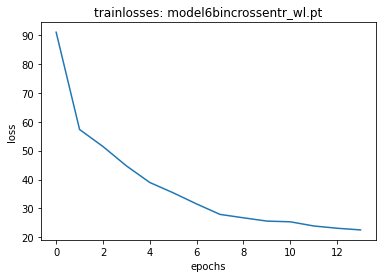

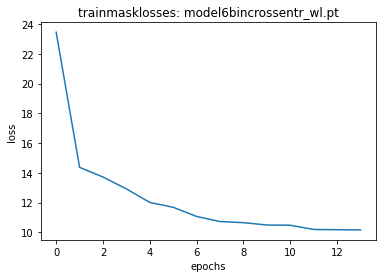

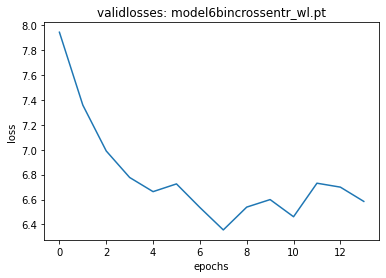

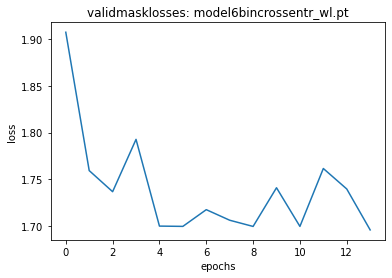

/home/szymi/miniconda3/envs/cv/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180549130/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
results = dict()
modelname ='model6bincrossentr_wl.pt'
print("modelname:", modelname)
with open( MODELPATH  + modelname + "_LOSSES.json" , "r" ) as f:
    (trainlosses, trainmasklosses), (validlosses, validmasklosses) = json.load(f)
plt.plot(trainlosses)
plt.title(f'trainlosses: {modelname}')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()
plt.plot(trainmasklosses)
plt.title(f'trainmasklosses: {modelname}')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()
plt.plot(validlosses)
plt.title(f'validlosses: {modelname}')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()
plt.plot(validmasklosses)
plt.title(f'validmasklosses: {modelname}')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

model = get_model()

BATCH_SIZE = 1
validdata = WGISDMaskedDataset('./wgisd', source = 'valid', transforms=testtransforms)
validloader = DataLoader(validdata, BATCH_SIZE, shuffle=True, num_workers = 1, collate_fn=lambda s: tuple(zip(*s)))
prec, rec, fsc = metrics(model, validloader)
results[modelname] = dict(precision = prec, recall = rec, fscore = fsc)

In [ ]:
# model6bincrossentr_wl.pt_LOSSES.json

In [5]:
import pandas as pd
pd.DataFrame.from_dict(results, orient = 'index')

,precision,recall,fscore
model6bincrossentr_wl.pt,0.836157,0.855763,0.845846


Final evaluation on test set:

In [6]:
model=get_model()
results = dict()
BATCH_SIZE = 1
validdata = WGISDMaskedDataset('./wgisd', source = 'test', transforms=testtransforms)
validloader = DataLoader(validdata, BATCH_SIZE, shuffle=True, num_workers = 1, collate_fn=lambda s: tuple(zip(*s)))
prec, rec, fsc = metrics(model, validloader)
results[modelname] = dict(precision = prec, recall = rec, fscore = fsc)
pd.DataFrame.from_dict(results, orient = 'index')

,precision,recall,fscore
model6bincrossentr_wl.pt,0.894241,0.861767,0.877703
